In [27]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.1  # Minimum distance constraint
    
    for _ in range(num_points):
        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(0.1, 1)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 1000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.743234, y = 0.179602, mass = 0.8722, force = [1.470585e+01, 8.994704e+00]]
  Particle 2: [x = 0.943969, y = 0.265016, mass = 0.9238, force = [-1.721253e+01, -5.076604e+00]]
  Particle 3: [x = 0.586729, y = 0.604210, mass = 0.5921, force = [2.506679e+00, -3.918100e+00]]

Data point 2:
  Particle 1: [x = 0.599471, y = 0.091349, mass = 0.5467, force = [5.578138e-01, 5.438616e+00]]
  Particle 2: [x = 0.177507, y = 0.937405, mass = 0.4885, force = [2.776056e-01, -4.805828e-01]]
  Particle 3: [x = 0.624292, y = 0.277060, mass = 0.3350, force = [-8.354194e-01, -4.958033e+00]]

Data point 3:
  Particle 1: [x = 0.066903, y = 0.976327, mass = 0.5192, force = [6.094282e-01, -9.367245e-02]]
  Particle 2: [x = 0.735581, y = 0.901505, mass = 0.5140, force = [-5.770435e-01, -6.822917e-03]]
  Particle 3: [x = 0.835970, y = 0.063873, mass = 0.1009, force = [-3.238467e-02, 1.004954e-01]]



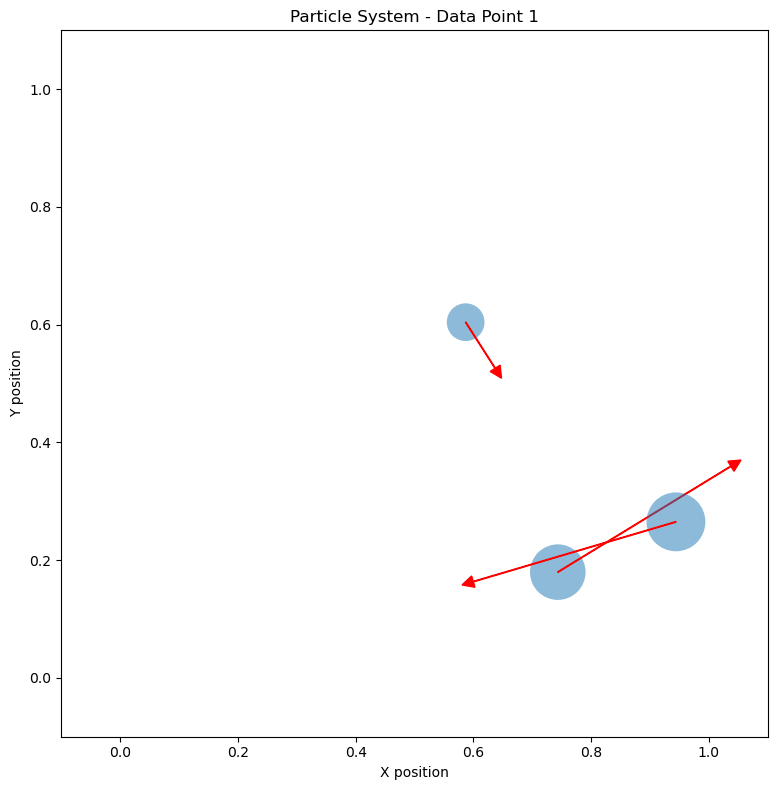

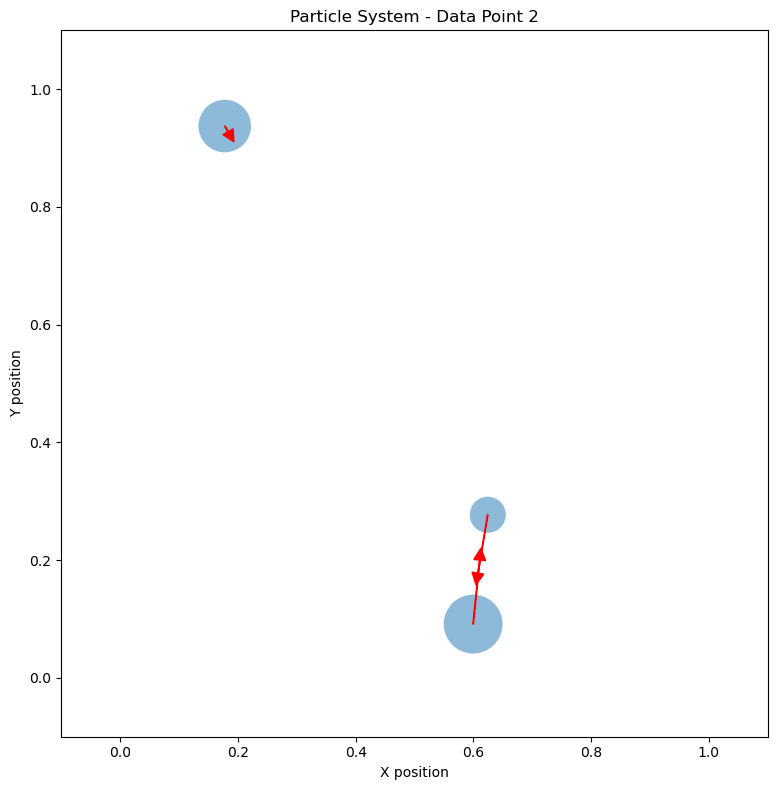

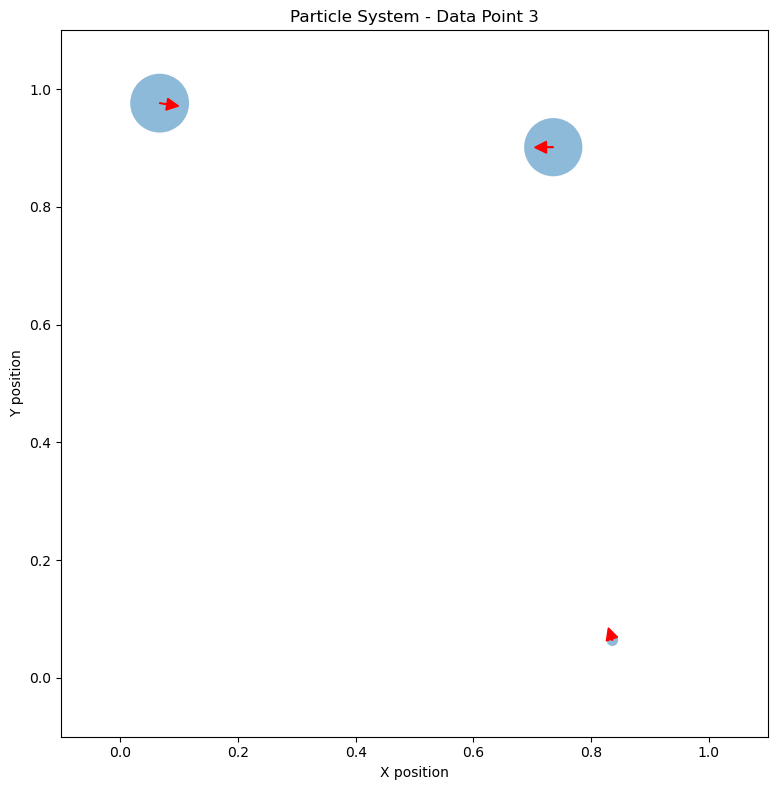

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 128),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.ReLU(),
            nn.Linear(5, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.1428, 0.1873, 0.1538],
        [0.7947, 0.9251, 0.1133],
        [0.1720, 0.1194, 0.1628]])
Input:
tensor([[0.1428, 0.1873, 0.1538],
        [0.7947, 0.9251, 0.1133],
        [0.1720, 0.1194, 0.1628]])

Output (forces):
tensor([[-0.3510,  0.3207],
        [-0.3578,  0.2920],
        [-0.3480,  0.3241]], grad_fn=<AddmmBackward0>)


In [30]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.7432341131917437, 0.17960185222551606, 0.8721578954472364, [14.705846157047377, 8.994703563076389]], [0.9439687151099869, 0.2650164862069416, 0.9237779667099589, [-17.212525645224567, -5.076603703949463]], [0.5867285999587672, 0.604209700434493, 0.5921107528109005, [2.5066794881771877, -3.9180998591269267]]]
[[0.5994710446344937, 0.09134927459719688, 0.5467438689753089, [0.5578138190531424, 5.438615614745351]], [0.1775069666587754, 0.9374052176294967, 0.48848672291554696, [0.27760561906991466, -0.480582825810303]], [0.6242924623430848, 0.2770602966735669, 0.3349811752147079, [-0.8354194381230571, -4.958032788935048]]]


tensor([[0.7432, 0.1796, 0.8722],
        [0.9440, 0.2650, 0.9238],
        [0.5867, 0.6042, 0.5921]])
tensor([[0.5995, 0.0913, 0.5467],
        [0.1775, 0.9374, 0.4885],
        [0.6243, 0.2771, 0.3350]])


tensor([[ 14.7058,   8.9947],
        [-17.2125,  -5.0766],
        [  2.5067,  -3.9181]])
tensor([[ 0.5578,  5.4386],
        [ 0.2776, -0.4806],
        [-0.8

Using device: cpu
Epoch [1/600], Loss: 29.9765, Learning Rate: 0.0190000000
Epoch [2/600], Loss: 29.3461, Learning Rate: 0.0180500000
Epoch [3/600], Loss: 28.1448, Learning Rate: 0.0171475000
Epoch [4/600], Loss: 28.5276, Learning Rate: 0.0162901250
Epoch [5/600], Loss: 25.1220, Learning Rate: 0.0154756187
Epoch [6/600], Loss: 22.3480, Learning Rate: 0.0147018378
Epoch [7/600], Loss: 19.8065, Learning Rate: 0.0139667459
Epoch [8/600], Loss: 16.3297, Learning Rate: 0.0132684086
Epoch [9/600], Loss: 13.1445, Learning Rate: 0.0126049882
Epoch [10/600], Loss: 12.3186, Learning Rate: 0.0119747388
Epoch [11/600], Loss: 12.5916, Learning Rate: 0.0113760018
Epoch [12/600], Loss: 11.3059, Learning Rate: 0.0108072018
Epoch [13/600], Loss: 9.5244, Learning Rate: 0.0102668417
Epoch [14/600], Loss: 8.9848, Learning Rate: 0.0097534996
Epoch [15/600], Loss: 10.8301, Learning Rate: 0.0092658246
Epoch [16/600], Loss: 8.6457, Learning Rate: 0.0088025334
Epoch [17/600], Loss: 8.2057, Learning Rate: 0.008

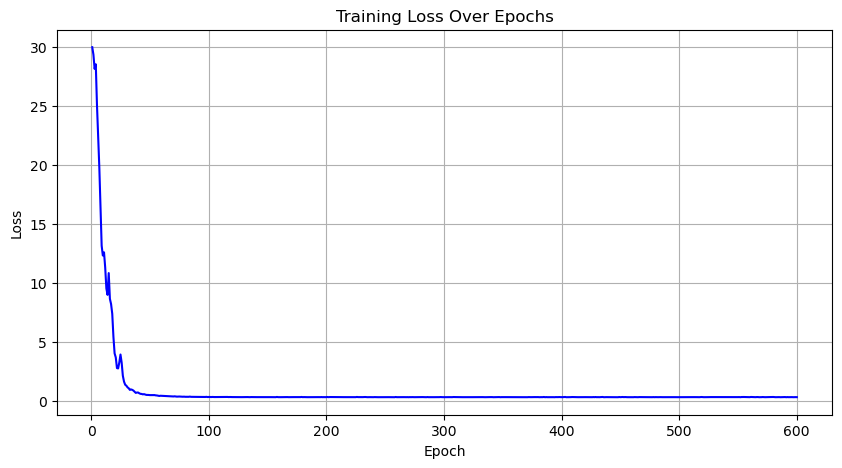

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 600  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [32]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 1.2681


In [33]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

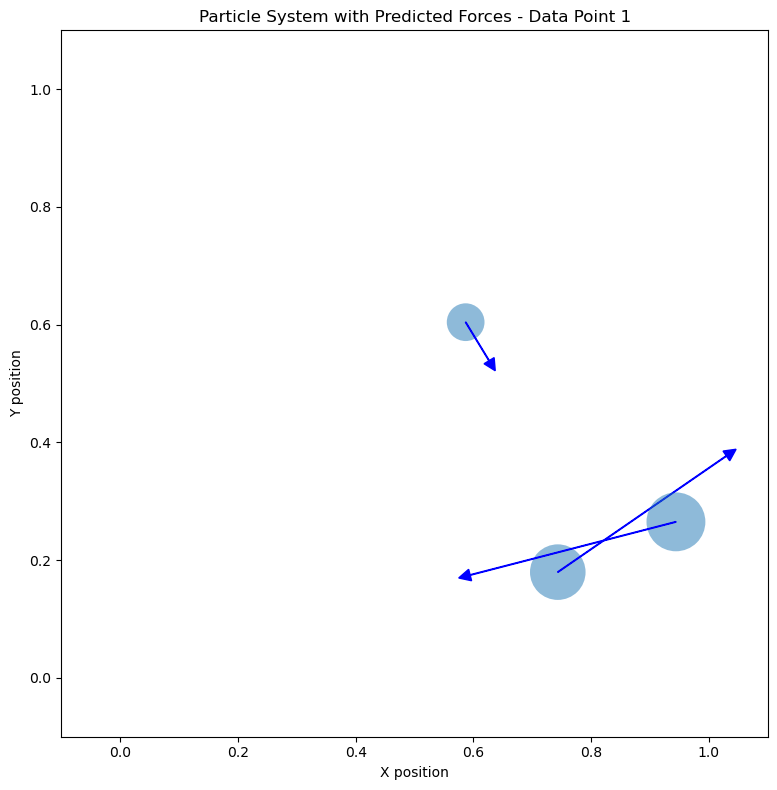

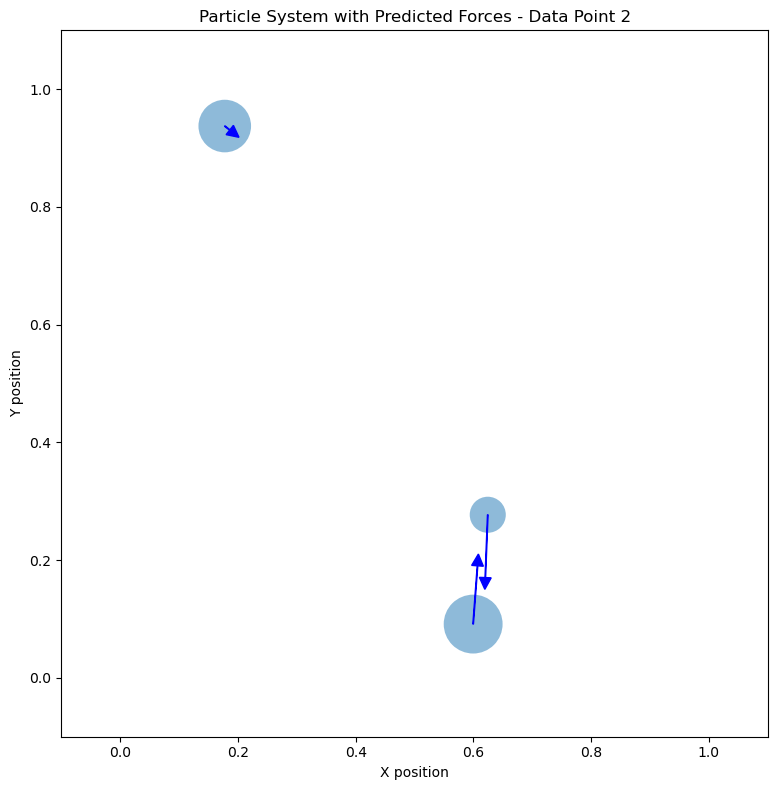

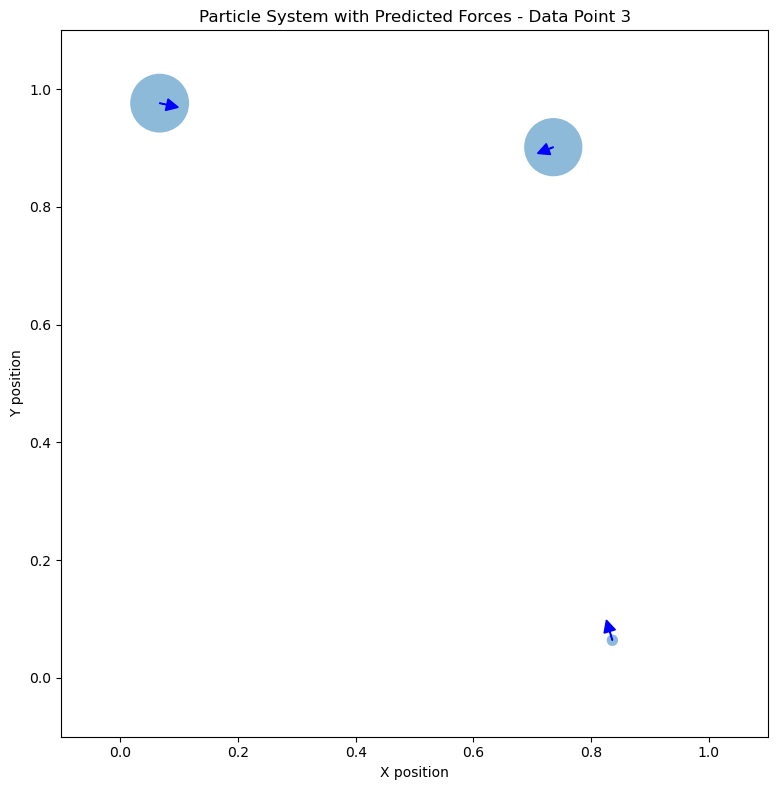

In [37]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

In [43]:
print(particle_dataset[0])

[[0.7432341131917437, 0.17960185222551606, 0.8721578954472364, [14.705846157047377, 8.994703563076389]], [0.9439687151099869, 0.2650164862069416, 0.9237779667099589, [-17.212525645224567, -5.076603703949463]], [0.5867285999587672, 0.604209700434493, 0.5921107528109005, [2.5066794881771877, -3.9180998591269267]]]


In [56]:
# Organize the data for PySR

input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor))


# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.detach().numpy() for tensor in predicted_forces])


In [60]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-","*", "/"],
    unary_operators=["sqrt"],
)

model.fit(input_data, predicted_forces)

/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.160e+04
Head worker occupation: 16.6%
Progress: 102 / 1200 total iterations (8.500%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.963e+00  7.971e+00  y₀ = sqrt(0.08466)
3           1.903e+00  3.094e-02  y₀ = x₅ * x₂
5           1.903e+00  3.317e-05  y₀ = 1.0277 * (x₂ * x₅)
6           1.892e+00  5.511e-03  y₀ = x₅ * sqrt(x₂ * x₁)
7           1.871e+00  1.110e-02  y₀ = x₅ * (x₂ * (x₁ + x₃))
8           1.871e+00  4.161e-04  y₀ = (x₅ * x₂) * (sqrt(x₃) + x₁)
9           1.864e+00  3.336e-03  y₀ = 0.066955 + ((x₅ - (x₄ - x₁)) * x₂)
10          1.856e+00  4.696e-03  y₀ = ((sqrt(x₁) - (x₄ - x₅)) * x₅) * x₂
11          1.845e+00  5.507e-03  y₀ = 0.066955 + ((x₅ - (x₄ * (x₄ - x₁))) * x₂)
12          1.843e+00  1.343e-03  y₀ = x₂ * ((x₁ - (x₄ - (sqrt(x₃) + 0.29023))) * x₅)
13          1.832e+00  5.682e-03  y

PySRRegressor.equations_ = [
[
	    pick         score                                           equation  \
	0         0.000000e+00                                         0.29092407   
	1         1.019086e-07                                   sqrt(0.08465992)   
	2   >>>>  3.094477e-02                                            x5 * x2   
	3         3.355795e-05                              (x5 * x2) * 1.0306951   
	4         5.510487e-03                                 x5 * sqrt(x2 * x1)   
	5         1.775236e-02                              (x5 - (x4 - x1)) * x2   
	6         1.141487e-03                ((x1 - (x4 - 1.0200071)) * x5) * x2   
	7         2.410612e-03                   x2 * (sqrt(x1 * x4) - (x4 - x5))   
	8         5.538232e-03                x2 * ((x1 * (x4 + x5)) - (x4 - x5))   
	9         1.216321e-03  (x2 + 0.27220118) * ((x1 * sqrt(x4)) - (x4 - x5))   
	10        8.237322e-03         ((x1 + x5) + (((x3 - x0) * x0) - x4)) * x2   
	11        2.553913e-03   x2 * ((sqrt(x1) + x5) + ((x0 * (x3 - x0)) - x4))   
	12        3.502849e-04  x2 * ((sqrt(x1) + x5) + ((x0 * (x3 - sqrt(x0))...   
	13        2.650779e-03  x2 * ((sqrt(x1) + x5) + (((x0 * (x3 - x0)) * 1...   
	14        1.802638e-03  ((((x4 - (sqrt(x1 * x4) + 0.2368959)) * -2.946...   
	15        2.328506e-03  (((x1 + x1) + x5) + ((((x3 - x0) / 0.40855834)...   
	16        2.483837e-03  ((sqrt(x1 + x1) + x5) + ((((x3 - x0) / 0.40855...   
	
	        loss  complexity  
	0   1.962543           1  
	1   1.962543           2  
	2   1.902742           3  
	3   1.902615           5  
	4   1.892159           6  
	5   1.858865           7  
	6   1.854626           9  
	7   1.850161          10  
	8   1.839943          11  
	9   1.837706          12  
	10  1.822631          13  
	11  1.817982          14  
	12  1.817345          15  
	13  1.812534          16  
	14  1.809270          17  
	15  1.800863          19  
	16  1.796396          20  
], [
	    pick     score                                           equation  \
	0         0.000000                                        0.021214675   
	1         0.001919                                   0.100944445 * x3   
	2   >>>>  0.007433                             (x0 - x3) * -0.2879505   
	3         0.005581                              (x3 - x0) * (x2 * x5)   
	4         0.002305                        (sqrt(x3) - x0) * (x2 * x5)   
	5         0.001872                       (x3 - (x0 * x0)) * (x2 * x5)   
	6         0.000906        ((((x3 - x0) * x5) * x3) / 0.32613292) * x0   
	7         0.001401  x0 * ((((x3 - x0) * x5) * (x3 * x2)) / 0.30027...   
	8         0.002228  (sqrt(x0) * (x5 * (((x3 - x0) / 0.5003172) + x...   
	9         0.001324  (sqrt(x0 * x5) * (x5 * (((x3 - x0) / 0.5003172...   
	10        0.000335  ((sqrt(x0) * (x5 * (((x3 - x0) / 0.5003172) + ...   
	11        0.005578  ((x5 * ((x4 * x2) + (((x3 - x0) * x0) / 0.4092...   
	
	        loss  complexity  
	0   0.771542           1  
	1   0.768587           3  
	2   0.757245           5  
	3   0.748839           7  
	4   0.747115           8  
	5   0.745718           9  
	6   0.744368          11  
	7   0.742285          13  
	8   0.740633          14  
	9   0.738674          16  
	10  0.738179          18  
	11  0.734073          19  
]]